# Tutorial for QA of Directional Field during Tractography

This tutorial is designed to illustrate the QA code used to generate the figure for the maximal directional field during Tractography. 

A quick recap of the tractography process:
NDMG uses dipy's CSA and CSD Models. These models use local and deterministic tracking respectively to 

From the 

Our visualization is different from Dipy's peak slicer tutorial: https://dipy.org/documentation/1.0.0./examples_built/tracking_introduction_eudx/#example-tracking-introduction-eudx 

The peak_slicer function they use generates a single sample 2-d directional field to represent the entire 3-d space. 

The following tutorial will 


In [1]:
import os

import nibabel as nib
import numpy as np

#dipy viewing 
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import load_tractogram, save_tractogram
from dipy.io.utils import (create_nifti_header, get_reference_info,
                           is_header_compatible)
from dipy.tracking.streamline import select_random_set_of_streamlines
from dipy.tracking.utils import density_map

from dipy.data.fetcher import (fetch_file_formats,
                               get_file_formats)


# dipy imports
from dipy.tracking.streamline import Streamlines
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.local_tracking import ParticleFilteringTracking
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.stopping_criterion import ActStoppingCriterion
from dipy.tracking.stopping_criterion import CmcStoppingCriterion

from dipy.reconst.dti import fractional_anisotropy, TensorModel, quantize_evecs
from dipy.reconst.shm import CsaOdfModel
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, recursive_response
from dipy.reconst.peak_direction_getter import EuDXDirectionGetter

from dipy.data import get_sphere
from dipy.direction import peaks_from_model, ProbabilisticDirectionGetter
from dipy.segment.mask import median_otsu
from dipy.core.gradients import gradient_table

from dipy.data import default_sphere

from dipy.viz import window, actor, has_fury, colormap

import matplotlib.pyplot as plt

## fury imports

import vtk
from vtk.util import numpy_support

import fury.shaders
from fury import layout
from fury.colormap import colormap_lookup_table, create_colormap, orient2rgb
from fury.utils import (lines_to_vtk_polydata, set_input, apply_affine,
                        numpy_to_vtk_points, numpy_to_vtk_colors,
                        numpy_to_vtk_matrix, shallow_copy,
                        set_polydata_vertices, set_polydata_triangles,)

from fury.actor import _makeNd

from fury.actor import line

# path = '/Users/wilsontang/Desktop/ndmg_outputs/sub_0025841_ses_1/sub-0025841/ses-1/dwi/fiber/streamlines.trk'

## Load Relevent Data to Reload Create Model

In [2]:
test_mask_AASS = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/MNI152NLin6_res-2x2x2_T1w_descr-brainmask.nii.gz')

In [3]:

bvals = np.loadtxt('/Users/wilsontang/Desktop/Tensor_Estimation_Data/bval.bval')
bvecs = np.loadtxt('/Users/wilsontang/Desktop/Tensor_Estimation_Data/bvec.bvec')
original_im = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/eddy_corrected_data_reor_RAS_nores.nii.gz')

# data_loaded_1 = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/desikan_space-MNI152NLin6_res-2x2x2_reor_RAS_nores_aligned_atlas.nii.gz').get_fdata()
# data_loaded_2 = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_in_dwi.nii.gz').get_fdata()
# data_loaded_3 = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_aligned_mni.nii.gz').get_fdata()
# atlas = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/desikan_space-MNI152NLin6_res-2x2x2.nii.gz').get_fdata()
data_original = original_im.get_fdata()

wm_in_dwi_data = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_wm_in_dwi.nii.gz').get_data().astype("bool")

sphere_mod = get_sphere('repulsion724')

In [4]:
print(data_original.shape)


print(wm_in_dwi_data.shape)

ren = window.Renderer()

(128, 124, 60, 93)
(128, 124, 60)


## CSA ODF Model Visualizations

In [5]:
#build gradient table
gtab = gradient_table(bvals, bvecs)

#running model
csa_model = CsaOdfModel(gtab, sh_order=6)

#
sphere_mod = get_sphere('repulsion724')

#extracting peaks
csa_peaks = peaks_from_model(model=csa_model,
                             data= data_original,
                             sphere=sphere_mod,
                             relative_peak_threshold=.5,
                             min_separation_angle=25,
                             npeaks = 5,
                             normalize_peaks=True,
                             mask = wm_in_dwi_data
                            )



In [6]:
#build odf 
csa_fit = csa_model.fit(data_original)
csa_odf = csa_fit.odf(sphere_mod)

In [7]:
## attempt to slice the peaks and values in the relevent directions to allow for different slice visualizations. 

# ##doesnt work

# y_slice_dirs = csa_peaks.peak_dirs[:,60:61,:,:,:]
# y_slice_vals = csa_peaks.peak_values[:,60:61,:,:]

# print(y_slice_dirs.shape)
# print(y_slice_vals.shape)



In [8]:
#clear window
window.clear(ren)

csa_fodf_spheres = actor.odf_slicer(csa_odf, sphere= sphere_mod, scale = 0.3, norm = True, colormap = 'plasma')




ren.add(csa_fodf_spheres)

print('Saving illustration as csa_odfs.png')

window.record(ren,out_path = 'csa_odfs.png', size = (900,900))

Saving illustration as csa_odfs.png


In [9]:
window.show(ren)

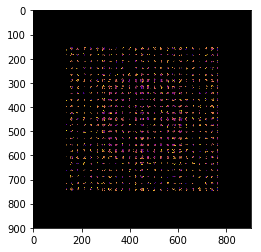

In [10]:
# open method used to open different extension image file 
im = plt.imread('csa_odfs.png')
  
# This method will show image in any image viewer  
plt.imshow(im) 

In [11]:
window.clear(ren)
base_actor = actor.peak_slicer(csa_peaks.peak_dirs,
                csa_peaks.peak_values,
                colors=None)

if has_fury:
    ren = window.Renderer()
    ren.add(base_actor)

    window.record(ren, out_path='csa_direction_field.png', size=(1500, 1500))


#     if interactive:
#         window.show(ren, size=(800, 800))



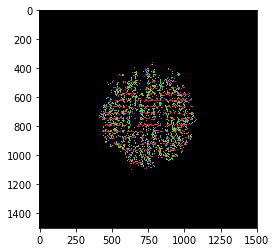

In [12]:
# open method used to open different extension image file 
im = plt.imread('csa_direction_field.png')
  
# This method will show image in any image viewer  
plt.imshow(im) 

## Attempt to make sense and slice the data.

Peak_Dirs - (x,y,z) 5 x 3 dimensional directions in each dimension

Peak_values - (x,y,z) 5 magnitude of the vector

Ideally we want to be able to slice along an n dimension 


In [13]:
print(np.unique(csa_peaks.peak_values).shape)
print(np.unique(csa_peaks.peak_dirs).shape)

print(np.unique(csa_peaks.peak_values))
print(np.unique(csa_peaks.peak_dirs))


(509399,)
(1530358,)
[0.         0.50000704 0.50001848 ... 1.         1.         1.        ]
[-0.99918788 -0.99895481 -0.9988605  ...  0.99857454  0.99908436
  0.99918788]


In [14]:
for n in range (128):
    print('Values in X dim: Dirs + Vals')
    #nothing in x
    print(csa_peaks.peak_dirs[n].shape)
    print(np.unique(csa_peaks.peak_dirs[n]))

    print(csa_peaks.peak_values[n].shape)
    print(np.unique(csa_peaks.peak_values[n]))

    print('Values in Y dim: Dirs + Vals')
    #nothing in y
    print(csa_peaks.peak_dirs[:,n].shape)
    print(np.unique(csa_peaks.peak_dirs[:,n]))

    print(csa_peaks.peak_values[:,n].shape)
    print(np.unique(csa_peaks.peak_values[:,n]))


#     print('Values in Z dim: Dirs + Vals')

#     print(csa_peaks.peak_dirs[:,:,n].shape)
#     print(np.unique(csa_peaks.peak_dirs[:,:,n]))

#     print(csa_peaks.peak_values[n].shape)
#     print(np.unique(csa_peaks.peak_values[:,:,n]))

Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.]
(124, 60, 5)
[0.]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[0.]
(128, 60, 5)
[0.]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[0.

[0.         0.50020152 0.50052363 0.50464226 0.50506066 0.50985445
 0.51239806 0.51494945 0.51705622 0.52080987 0.52159497 0.52237048
 0.52251343 0.52437817 0.52528833 0.525594   0.52645881 0.52751091
 0.52798979 0.53088843 0.53201774 0.53219506 0.53308394 0.53448555
 0.53503342 0.53751254 0.53878474 0.5390302  0.53978353 0.54014345
 0.54143763 0.54184301 0.54184448 0.54236723 0.54275404 0.54395283
 0.54507121 0.54541547 0.54660822 0.54721459 0.54829363 0.54919226
 0.55030051 0.55090774 0.55126888 0.55183786 0.55321996 0.55379122
 0.55405252 0.55421441 0.55492427 0.55518922 0.55627808 0.55647138
 0.55695898 0.55728872 0.55870436 0.55929705 0.56086098 0.56144364
 0.56202294 0.56342124 0.56356186 0.56404332 0.56482996 0.56689545
 0.56711475 0.56809105 0.56910771 0.56923458 0.56974951 0.57144885
 0.57238607 0.57279163 0.57287697 0.57411804 0.5744828  0.57528142
 0.57731231 0.57774827 0.57808035 0.57912481 0.57928776 0.58010651
 0.5803861  0.58216107 0.58434495 0.58786537 0.58838145 0.5899

[-0.97830255 -0.97731079 -0.96511081 ...  0.98698948  0.99000031
  0.99119054]
(124, 60, 5)
[0.         0.50258534 0.50313542 0.50667969 0.50769532 0.50963118
 0.51033461 0.51466339 0.51525037 0.51586968 0.51646961 0.51739143
 0.51827369 0.51970052 0.52160557 0.5222407  0.52867762 0.52897225
 0.53135321 0.53197854 0.5378646  0.53824893 0.53879084 0.54055089
 0.54135866 0.54173623 0.54202929 0.54328644 0.54361865 0.54594001
 0.5460604  0.5461809  0.54882048 0.54920926 0.55069107 0.55163768
 0.55531494 0.55642226 0.55689691 0.55773559 0.55775713 0.55779034
 0.56112577 0.56182291 0.56231693 0.56504715 0.56638497 0.56693137
 0.56757163 0.57009574 0.57170653 0.57218654 0.57430449 0.5745589
 0.57482367 0.57552933 0.57557559 0.57616257 0.57678047 0.57911407
 0.57922989 0.57924647 0.57975068 0.58006029 0.58101913 0.58109769
 0.58160993 0.5838228  0.58451642 0.58517269 0.58567213 0.59451332
 0.59456809 0.59616341 0.5983413  0.59854001 0.59889423 0.60432014
 0.60725954 0.60764811 0.60852837 0.61

[-0.99918788 -0.99848131 -0.99537642 ...  0.99569081  0.99659146
  0.99918788]
(128, 60, 5)
[0.         0.50156448 0.5031398  ... 1.         1.         1.        ]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99569081 ...  0.99746776  0.99848131
  0.99918788]
(124, 60, 5)
[0.         0.50003233 0.50169641 ... 1.         1.         1.        ]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99537642 ...  0.99659146  0.99746776
  0.99918788]
(128, 60, 5)
[0.         0.50040877 0.50082582 ... 1.         1.         1.        ]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99537642 ...  0.99559269  0.99569081
  0.99848131]
(124, 60, 5)
[0.         0.50033174 0.50300548 ... 1.         1.         1.        ]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99746776 ...  0.99559269  0.99569081
  0.99918788]
(128, 60, 5)
[0.         0.50045488 0.50050609 ... 0.99993854 0.99994151 1.        ]


[0.         0.50113167 0.50192811 ... 0.99976644 0.99980374 1.        ]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99746776 ...  0.99659146  0.99746776
  0.99918788]
(128, 60, 5)
[0.         0.50011917 0.50016493 ... 1.         1.         1.        ]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[-0.99918788 -0.99850328 -0.99848131 ...  0.99734204  0.99746776
  0.99918788]
(124, 60, 5)
[0.         0.50034987 0.50036161 ... 0.99996915 0.99999669 1.        ]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99746776 ...  0.99569081  0.99659146
  0.99918788]
(128, 60, 5)
[0.         0.50106627 0.50108419 ... 1.         1.         1.        ]
Values in X dim: Dirs + Vals
(124, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99760347 ...  0.99659146  0.99746776
  0.99918788]
(124, 60, 5)
[0.         0.50077804 0.50086599 ... 1.         1.         1.        ]
Values in Y dim: Dirs + Vals
(128, 60, 5, 3)
[-0.99918788 -0.99848131 -0.99746776 ...  0.997

[0.         0.50016477 0.50158034 0.50374226 0.50496683 0.5093406
 0.51008904 0.51252303 0.51269437 0.51297372 0.51336902 0.52299426
 0.52432263 0.52710355 0.52761784 0.53037474 0.53100684 0.53516091
 0.53592808 0.5363272  0.53722849 0.53744394 0.5386236  0.53999991
 0.54538623 0.54947191 0.54951029 0.55452646 0.56062015 0.56167929
 0.562249   0.56399698 0.56841721 0.56967041 0.56996046 0.57216176
 0.57225572 0.57615463 0.57756108 0.58267146 0.58352774 0.58705134
 0.58737984 0.58990543 0.59161142 0.59222519 0.59483062 0.59771527
 0.59951295 0.60153334 0.60553893 0.60657368 0.60943824 0.61121804
 0.61180819 0.61318047 0.61346067 0.61647589 0.61908798 0.62346338
 0.62430023 0.62630226 0.63045367 0.63069012 0.63185759 0.63321677
 0.6347121  0.63585676 0.63648422 0.637451   0.63992563 0.64000582
 0.64232528 0.64296494 0.64363982 0.64555131 0.64614319 0.64628607
 0.64862803 0.65220647 0.6548588  0.65493989 0.65864992 0.65886812
 0.66032182 0.66033632 0.66074383 0.66079021 0.66099811 0.66246

IndexError: index 124 is out of bounds for axis 1 with size 124

In [ ]:
n = 50

print('')
print('Values in X dim: Dirs + Vals')
#nothing in x
print(csa_peaks.peak_dirs[n].shape)
print(np.unique(csa_peaks.peak_dirs[n]))

print(csa_peaks.peak_values[n].shape)
print(np.unique(csa_peaks.peak_values[n]))

print('')
print('Values in Y dim: Dirs + Vals')
#nothing in y
print(csa_peaks.peak_dirs[:,n].shape)
print(np.unique(csa_peaks.peak_dirs[:,n]))

print(csa_peaks.peak_values[:,n].shape)
print(np.unique(csa_peaks.peak_values[:,n]))

print('')
print('Values in Z dim: Dirs + Vals')

print(csa_peaks.peak_dirs[:,:,n].shape)
print(np.unique(csa_peaks.peak_dirs[:,:,n]))

print(csa_peaks.peak_values[n].shape)
print(np.unique(csa_peaks.peak_values[:,:,n]))

#all directions are in the 3rd dimension? (z)

n = 4
print('')
print('Values in peaks dim: Dirs + Vals')
print(csa_peaks.peak_dirs[:,:,:,n].shape)
print(np.unique(csa_peaks.peak_dirs[:,:,:,n]))

print(csa_peaks.peak_values[:,:,:,n].shape)
print(np.unique(csa_peaks.peak_values[:,:,:,n]))

#directions in peaks 

n = 0
print('')
print('Values in x,y,z: representative Dir peaks, n = ' + str(n))
print(csa_peaks.peak_dirs[:,:,:,:,n].shape)
print(np.unique(csa_peaks.peak_dirs[:,:,:,:,n]))

n = 1
print('')
print('Values in x,y,z: representative Dir peaks, n = ' + str(n))
print(csa_peaks.peak_dirs[:,:,:,:,n].shape)
print(np.unique(csa_peaks.peak_dirs[:,:,:,:,n]))

n = 2
print('')
print('Values in x,y,z: representative Dir peaks, n = ' + str(n))
print(csa_peaks.peak_dirs[:,:,:,:,n].shape)
print(np.unique(csa_peaks.peak_dirs[:,:,:,:,n]))



n = 2
print('')
print('Values in x,y,z: representative Dir peaks, n = ' + str(n))
print(csa_peaks.peak_dirs[50,:,:,:,n].shape)
print(np.unique(csa_peaks.peak_dirs[50,:,:,:,n]))

In [ ]:
a = np.zeros([128,124,60,5,3])
print(a.shape)

a[:,:,:,1,:] = np.ones([128,124,60,3])

print(a[:,:,:,1,:])
print(a[:,:,:,0,:])
print(a[:,:,:,2,:])

b = np.amax(a,axis = 3)
print(b.shape)



dirs_args = np.argmax(a,axis=3)
print(dirs_args.shape)
print(np.unique(dirs_args))

vals_args = np.argmax(csa_peaks.peak_values,axis=3)
print(vals_args.shape)
print(np.unique(vals_args))

print(csa_peaks.peak_values.shape)


# Trying to visualize via quiver



In [ ]:
x = np.arange(0,2.2,0.2)
y = np.arange(0,2.2,0.2)

print(x.shape)
print(x)
print(y.shape)
print(y)
X, Y = np.meshgrid(x, y)

print(X.shape)
print(Y.shape)
u = np.cos(X)*Y
v = np.sin(y)*Y

print(u.shape)
print(v.shape)

fig, ax = plt.subplots(figsize=(7,7))
ax.quiver(X,Y,u,v)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.axis([-0.2, 2.3, -0.2, 2.3])
ax.set_aspect('equal')

plt.show()

In [ ]:
##test 

x = np.arange(0,10,10/128)
y = np.arange(0,10,10/128)
z = np.arange(60)

dim1, dim2 = np.meshgrid(x,y)

print(dim1.shape)
print(dim2.shape)

u = np.cos(dim1)*dim2
v = np.sin(y)*dim2

print(u.shape)
print(v.shape)

fig, ax = plt.subplots(figsize=(128,128))
ax.quiver(X,Y,u,v)

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.axis([-0.2, 10, -0.2, 10])
ax.set_aspect('equal')

plt.show()
#slice along Z, X,Y .Z = 50



fig,ax = plt.plot()



# Adjusting peak_slicer to slice in different directions



In [ ]:
def peak_slicer_d(peaks_dirs, peaks_values=None, mask=None, affine=None,
                colors=(1, 0, 0), opacity=1., linewidth=1,
                lod=False, lod_points=10 ** 4, lod_points_size=3):
    """Visualize peak directions as given from ``peaks_from_model``.

    Parameters
    ----------
    peaks_dirs : ndarray
        Peak directions. The shape of the array can be (M, 3) or (X, M, 3) or
        (X, Y, M, 3) or (X, Y, Z, M, 3)
    peaks_values : ndarray
        Peak values. The shape of the array can be (M, ) or (X, M) or
        (X, Y, M) or (X, Y, Z, M)
    affine : array
        4x4 transformation array from native coordinates to world coordinates
    mask : ndarray
        3D mask
    colors : tuple or None
        Default red color. If None then every peak gets an orientation color
        in similarity to a DEC map.

    opacity : float, optional
        Takes values from 0 (fully transparent) to 1 (opaque)

    linewidth : float, optional
        Line thickness. Default is 1.

    lod : bool
        Use vtkLODActor(level of detail) rather than vtkActor.
        Default is False. Level of detail actors do not render the full
        geometry when the frame rate is low.
    lod_points : int
        Number of points to be used when LOD is in effect. Default is 10000.
    lod_points_size : int
        Size of points when lod is in effect. Default is 3.

    Returns
    -------
    vtkActor

    See Also
    --------
    fury.actor.odf_slicer

    """
    peaks_dirs = np.asarray(peaks_dirs)
    if peaks_dirs.ndim > 5:
        raise ValueError("Wrong shape")

    peaks_dirs = _makeNd(peaks_dirs, 5)
    if peaks_values is not None:
        peaks_values = _makeNd(peaks_values, 4)

    grid_shape = np.array(peaks_dirs.shape[:3])

    if mask is None:
        mask = np.ones(grid_shape).astype(np.bool)

    class PeakSlicerActor(vtk.vtkLODActor):
        def __init__(self):
            self.line = None

        def display_extent(self, x1, x2, y1, y2, z1, z2):

            tmp_mask = np.zeros(grid_shape, dtype=np.bool)
            tmp_mask[x1:x2 + 1, y1:y2 + 1, z1:z2 + 1] = True
            tmp_mask = np.bitwise_and(tmp_mask, mask)

            ijk = np.ascontiguousarray(np.array(np.nonzero(tmp_mask)).T)
            if len(ijk) == 0:
                self.SetMapper(None)
                return
            if affine is not None:
                ijk_trans = np.ascontiguousarray(apply_affine(affine, ijk))
            list_dirs = []
            for index, center in enumerate(ijk):
                # center = tuple(center)
                if affine is None:
                    xyz = center[:, None]
                else:
                    xyz = ijk_trans[index][:, None]
                xyz = xyz.T
                for i in range(peaks_dirs[tuple(center)].shape[-2]):

                    if peaks_values is not None:
                        pv = peaks_values[tuple(center)][i]
                    else:
                        pv = 1.
                    symm = np.vstack((-peaks_dirs[tuple(center)][i] * pv + xyz,
                                      peaks_dirs[tuple(center)][i] * pv + xyz))
                    list_dirs.append(symm)

            self.line = line(list_dirs, colors=colors,
                             opacity=opacity, linewidth=linewidth,
                             lod=lod, lod_points=lod_points,
                             lod_points_size=lod_points_size)

            self.SetProperty(self.line.GetProperty())
            self.SetMapper(self.line.GetMapper())

        def display(self, x=None, y=None, z=None):
            if x is None and y is None and z is None:
                self.display_extent(0, szx - 1, 0, szy - 1,
                                    int(np.floor(szz/2)), int(np.floor(szz/2)))
            if x is not None:
                self.display_extent(x, x, 0, szy - 1, 0, szz - 1)
            if y is not None:
                self.display_extent(0, szx - 1, y, y, 0, szz - 1)
            if z is not None:
                self.display_extent(0, szx - 1, 0, szy - 1, z, z)

    peak_actor = PeakSlicerActor()

    szx, szy, szz = grid_shape
    peak_actor.display_extent(0, szx - 1, 0, szy - 1,
                              int(np.floor(szz / 2)), int(np.floor(szz / 2)))

    return peak_actor

## Testing Fury peak_slicer shapes

In [ ]:
grid_shape = np.array(csa_peaks.peak_dirs.shape[:3])
print(grid_shape)


#
tmp_mask = np.zeros(grid_shape, dtype=np.bool)
print(tmp_mask.shape)
print(np.unique(tmp_mask))
# tmp_mask[:,:,:] = True
# tmp_mask.fill(True)
# print(tmp_mask.shape)

tmp_mask = np.ones(grid_shape, dtype=np.bool)

print(tmp_mask.shape)
print(np.unique(tmp_mask))

ijk = np.ascontiguousarray(np.array(np.nonzero(tmp_mask)).T)
print(ijk.shape)
print(ijk)

In [ ]:
# max_peak = csa_peaks.peak_dirs.max(axis = 3)

# print(max_peak.shape)

# np.argmax(csa_peaks.peak_dirs, axis = 3)

grid_shape = csa_peaks.peak_dirs.shape
print(csa_peaks.peak_dirs.shape)

new_peaks_z = csa_peaks.peak_dirs[:,:,:,0,:]
new_vals_z = csa_peaks.peak_values[:,:,:,0]

new_peaks_z = new_peaks_z.reshape((128,124,60,1,3))
new_vals_z = new_vals_z.reshape((128,124,60,1))
print(new_peaks_z.shape)
print(new_vals_z.shape)


mask = np.zeros(grid_shape[:3]).astype(np.bool)
mask[:,:,50] = True 

# plt.imshow(new_peaks,new_vals)

# print(new_peaks[:,0])


In [ ]:
window.clear(ren)
# base_actor = actor.peak_slicer(csa_peaks.peak_dirs,csa_peaks.peak_values, colors = None)
base_actor = actor.peak_slicer(csa_peaks.peak_dirs,mask = mask ,colors = None)
# base_actor = peak_slicer_d(new_peaks_z,colors=None)

print(base_actor)
if has_fury:
    ren = window.Renderer()
    ren.add(base_actor)

    window.record(ren, out_path='csa_direction_field_slice_z_all.png', size=(1500, 1500))


    window.show(ren)
#     if interactive:
#         window.show(ren, size=(800, 800))


In [ ]:
# open method used to open different extension image file 
im = plt.imread('csa_direction_field_slice.png')
  
# This method will show image in any image viewer  
plt.imshow(im) 

In [ ]:
new_peaks_x = csa_peaks.peak_dirs[:,50:52,:,:,:]
new_vals_x = csa_peaks.peak_values[:,50:52,:,:]

print(new_peaks_x.shape)
new_peaks_x = new_peaks_x.reshape((128,2,60,5,3))
new_vals_x = new_vals_x.reshape((128,2,60,5))
print(new_peaks_x.shape)
print(new_vals_x.shape)

new_peaks_x = csa_peaks.peak_dirs[50:100,:,:,:,:]
new_vals_x = csa_peaks.peak_values[50:100,:,:,:]

new_peaks_x = new_peaks_x.reshape((50,124,60,5,3))
new_vals_x = new_vals_x.reshape((50,124,60,5))
print(new_peaks_x.shape)
print(new_vals_x.shape)


# Attempt to use Fury Arrow Functionality

In [15]:
from fury import window, actor

scene = window.Scene()
centers = np.random.rand(5, 3)
directions = np.random.rand(5, 3)
heights = np.random.rand(5)
arrow_actor = actor.arrow(centers, directions, (1, 1, 1), heights)
scene.add(arrow_actor)
window.show(scene)

In [16]:
print(csa_peaks.peak_dirs.shape)
print(csa_peaks.peak_values.shape)
print(csa_peaks.peak_dirs.shape[0])


(128, 124, 60, 5, 3)
(128, 124, 60, 5)
128


In [17]:
fury.__version__

'0.4.0'

In [ ]:
x = 1 
y = 1 
z = 0
peak_dirs = csa_peaks.peak_dirs
a = peak_dirs[x,y,z,0,:].sum()+ 0.000001



peak_dirs[x,y,z,0,:]/(peak_dirs[x,y,z,0,:].sum()+ 0.000001)

In [ ]:
def plot_3_d_directions(peak_dirs,peak_values):

    #initialize 
    centers = []
    directions = []
    heights = []
    directions_colors = []

    peaks_vals_max = np.amax(peak_dirs,axis = 3)


    #get max
    peaks_vals_max_arg = np.argmax(peak_values,axis = 3)

    print(peaks_vals_max_arg.shape)
    print(peaks_vals_max_arg)
    peaks_dirs = csa_peaks.peak_dirs
    print(peaks_dirs.shape)

    
    print('Generating Arrows')
    for x in range(peaks_dirs.shape[0]):
        for y in range(peaks_dirs.shape[1]): 
            for z in range(peaks_dirs.shape[2]):
                centers.append([x,y,z])
                directions.append(peaks_dirs[x,y,z,0,:])
                #normalize directions and add
                #directions_colors.append(peak_dirs[x,y,z,0,:]/(peak_dirs[x,y,z,0,:].sum()+ 0.000001))
                #directions_colors.append(peaks_dirs[x,y,0,0,:])
                heights.append(peaks_vals_max[x,y,z])


    centers = np.asarray(centers)
    directions = np.asarray(directions)
    
    #multiply normalized directions to make rgb
    #directions_colors = np.asarray(directions_colors)
    directions_colors = 255*directions

    heights = np.asarray(heights)

    print(centers.shape)
    print(directions.shape)
    print(directions_colors.shape)
    print(heights.shape)
    
    print('Plotting Arrows')
    scene = window.Scene()
    arrow_actor = actor.arrow(centers, directions, directions_colors, heights)

    scene.add(arrow_actor)

    window.show(scene, size = (900,900), png_magnify = 5)

# def plot_sliced_directions(peak_dirs,peak_values):


new_peaks_x = csa_peaks.peak_dirs[:,50,:,:,:]
new_vals_x = csa_peaks.peak_values[:,50,:,:]

new_peaks_x = new_peaks_x.reshape((128,1,60,5,3))
new_vals_x = new_vals_x.reshape((128,1,60,5))
print(new_peaks_x.shape)
print(new_vals_x.shape)

plot_3_d_directions(csa_peaks.peak_dirs,csa_peaks.peak_values)
# plot_3_d_directions(new_peaks_x,new_vals_x)

(128, 1, 60, 5, 3)
(128, 1, 60, 5)
(128, 124, 60)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(128, 124, 60, 5, 3)
Generating Arrows
(952320, 3)
(952320, 3)
(952320, 3)
(952320, 3)
Plotting Arrows


In [ ]:
print(np.unique(peak_dirs))
print(np.unique(peak_values))

In [ ]:
x = 50
y = 70
z = 30

print(peak_dirs[x,y,z,0,:])
print(peak_dirs[x,y,z,0,:].sum())

print(np.nan_to_num(peak_dirs[x,y,z,0,:]/(peak_dirs[x,y,z,0,:].sum()) ))

print('still running')

In [ ]:
#initialize 
peak_dirs = csa_peaks.peak_dirs 
peak_values = csa_peaks.peak_values
centers = []
directions = []
heights = []
directions_colors = []

peaks_vals_max = np.amax(peak_dirs,axis = 3)


#get max
peaks_vals_max_arg = np.argmax(peak_values,axis = 3)

print(peaks_vals_max_arg.shape)
peaks_dirs = csa_peaks.peak_dirs
print(peaks_dirs.shape)

    
print('Generating Arrows')
for x in range(peaks_dirs.shape[0]):
    for y in range(peaks_dirs.shape[1]): 
        for z in range(peaks_dirs.shape[2]):
            centers.append([x,y,z])
            directions.append(peaks_dirs[x,y,z,0,:])
            #normalize directions and convert NaN to zeros
#             directions_colors.append(np.nan_to_num(peak_dirs[x,y,z,0,:]/(peak_dirs[x,y,z,0,:].sum())) )
            #directions_colors.append(peaks_dirs[x,y,0,0,:])
            heights.append(peaks_vals_max[x,y,z])


centers = np.asarray(centers)
directions = np.asarray(directions)
    
# #multiply normalized directions to make rgb
# directions_colors = np.asarray(directions_colors)
# print(directions_colors)
# print(np.unique(directions_colors))
directions_colors = directions*255
    
#     poly_data=vtk.vtkPolyData()
#     directions_colors = numpy_to_vtk_colors(255*directions)

heights = np.asarray(heights)

print(centers.shape)
print(directions.shape)
print(directions_colors.shape)
print(heights.shape)
    
print(directions_colors)
print(np.unique(directions_colors))
print('Plotting Arrows')
scene = window.Scene()
arrow_actor = actor.arrow(centers, directions, directions_colors, heights)

scene.add(arrow_actor)

window.show(scene, size = (900,900), png_magnify = 5)


In [ ]:
window.clear(ren)
base_actor = actor.peak_slicer(new_peaks_x,
                new_vals_x,
                colors=None)



print(base_actor)
if has_fury:
    ren = window.Renderer()
    ren.add(base_actor)
    
    window.record(ren, out_path='csa_direction_field_slice_x.png', size=(1500, 1500))

    window.show(ren)

In [ ]:
# open method used to open different extension image file 
im = plt.imread('csa_direction_field_slice_x.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [ ]:
csa_fodf_spheres.GetProperty().SetOpacity(0.4)

ren.add(csa_fodf_spheres)

print('Saving illustration as csa_both.png')

window.record(ren,out_path = 'csa_both.png', size = (1200,1200))

window.show(ren)

In [ ]:
# open method used to open different extension image file 
im = plt.imread('csa_both.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

## CSD Model Visualizations

In [ ]:
#build response
response = recursive_response(
                gtab,
                data_original,
                mask =wm_in_dwi_data,
                sh_order=6,
                peak_thr=0.01,
                init_fa=0.08,
                init_trace=0.0021,
                iter=8,
                convergence=0.001,
                parallel=False,
            )

csd_model = ConstrainedSphericalDeconvModel(gtab,response,sh_order=6)

In [ ]:
csd_fit = csd_model.fit(data_original)





In [ ]:
csd_odf = csd_fit.odf(sphere_mod)

In [31]:
#show fiber odfs

#clear window
window.clear(ren)

fodf_spheres = actor.odf_slicer(csd_odf, sphere= sphere_mod, scale = 0.9, norm = False, colormap = 'plasma')

ren.add(fodf_spheres)

print('Saving illustration as csd_odfs.png')

window.record(ren,out_path = 'csd_odfs.png', size = (900,900))


Saving illustration as csd_odfs.png


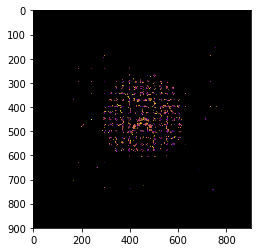

In [62]:
# open method used to open different extension image file 
im = plt.imread('csd_odfs.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [32]:
csd_peaks = peaks_from_model(model = csd_model,
                            data = data_original,
                            sphere = sphere_mod,
                            relative_peak_threshold = 0.5,
                            min_separation_angle = 25,
                            npeaks = 5,
                            normalize_peaks=True,
                            mask = wm_in_dwi_data)


Saving illustration as csd_peaks.png


In [34]:
window.clear(ren)

fodf_peaks= actor.peak_slicer(csd_peaks.peak_dirs,csd_peaks.peak_values)
ren.add(fodf_peaks)

print('Saving illustration as csd_peaks.png')

window.record(ren,out_path = 'csd_peaks.png', size = (1200,1200))

Saving illustration as csd_peaks.png


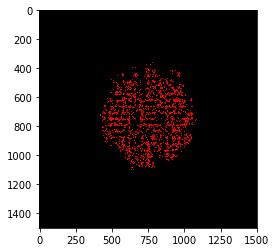

In [63]:
# open method used to open different extension image file 
im = plt.imread('csd_peaks.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [35]:
fodf_spheres.GetProperty().SetOpacity(0.4)

ren.add(fodf_spheres)

print('Saving illustration as csd_both.png')


window.record(ren,out_path = 'csd_both.png', size = (1200,1200))

Saving illustration as csd_both.png


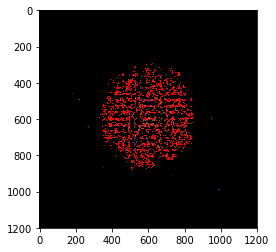

In [64]:
# open method used to open different extension image file 
im = plt.imread('csd_both.png')
  
# This method will show image in any image viewer  
plt.imshow(im)



## Attempt to visualize streamlines



In [68]:

stream_affine = np.eye(4) 

print('Building Seeds')
#build seeds
seeds = utils.random_seeds_from_mask(
        wm_in_dwi_data,
        affine=stream_affine,
        seeds_count= 1 ,
        seed_count_per_voxel=True,
    )




Building Seeds


In [72]:
print('Selecting Stopping Criteria')
#build stopping criteria
# tiss_classifier = BinaryStoppingCriterion(wm_in_dwi_data)

gm_mask_data = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_gm_in_dwi.nii.gz').get_data()

vent_csf_in_dwi_data = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_csf_mask_dwi.nii.gz').get_data()

wm_in_dwi = nib.load('/Users/wilsontang/Desktop/Tensor_Estimation_Data/t1w_wm_in_dwi.nii.gz')

voxel_size = np.average(wm_in_dwi.get_header()["pixdim"][1:4])
step_size = 0.2
    
tiss_classifier = CmcStoppingCriterion.from_pve(
    wm_in_dwi_data,
    gm_mask_data,
    vent_csf_in_dwi_data,
    step_size=step_size,
    average_voxel_size=voxel_size,
)


Selecting Stopping Criteria


/Users/wilsontang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  # This is added back by InteractiveShellApp.init_path()


In [88]:

print('Streamline Generator- w/ CMC and Particle')

#create streamline  generator
streamline_generator = ParticleFilteringTracking(
                csa_peaks,
                tiss_classifier,
                seeds,
                stream_affine,
                max_cross= 1 ,
                step_size=0.5,
                maxlen=1000,
                pft_back_tracking_dist=2,
                pft_front_tracking_dist=1,
                particle_count=15,
                return_all=False,
            )

Streamline Generator- w/ CMC and Particle


In [89]:
streamlines_cmc_particle = Streamlines(streamline_generator)

In [90]:
window.clear(ren)

if has_fury:
    r = window.Renderer()
    r.add(actor.line(streamlines_cmc_particle, colormap.line_colors(streamlines_cmc_particle)))
    window.record(r, out_path='tractogram_pft_cmc_particle.png',
                  size=(800, 800))

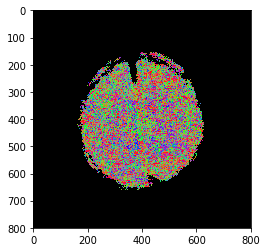

In [91]:
# open method used to open different extension image file 
im = plt.imread('tractogram_pft_cmc_particle.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [92]:
print('Streamline Generator w/CMC and Local')

#create streamline  generator
streamline_generator = LocalTracking(
                csa_peaks,
                tiss_classifier,
                seeds,
                stream_affine,
                max_cross= 1 ,
                step_size=0.5,
                maxlen=1000,
#                 pft_back_tracking_dist=2,
#                 pft_front_tracking_dist=1,
#                 particle_count=15,
                return_all=False,
            )

Streamline Generator w/CMC and Local


In [93]:
streamlines_cmc_local = Streamlines(streamline_generator)

In [94]:
window.clear(ren)

if has_fury:
    r = window.Renderer()
    r.add(actor.line(streamlines_cmc_local, colormap.line_colors(streamlines_cmc_local)))
    window.record(r, out_path='tractogram_pft_cmc_local.png',
                  size=(800, 800))

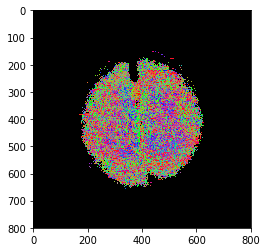

In [95]:
# open method used to open different extension image file 
im = plt.imread('tractogram_pft_cmc_local.png')
  
# This method will show image in any image viewer  
plt.imshow(im)

In [ ]:
image_actor_x = image_actor_z.copy()
x_midpoint = int(np.round(shape[0] / 2))
image_actor_x.display_extent(x_midpoint,
                             x_midpoint, 0,
                             shape[1] - 1,
                             0,
                             shape[2] - 1)

image_actor_y = image_actor_z.copy()
y_midpoint = int(np.round(shape[1] / 2))
image_actor_y.display_extent(0,
                             shape[0] - 1,
                             y_midpoint,
                             y_midpoint,
                             0,
                             shape[2] - 1)


scene.add(stream_actor)
scene.add(image_actor_z)
scene.add(image_actor_x)
scene.add(image_actor_y)

In [ ]:
show_m = window.ShowManager(scene, size=(1200, 900))
show_m.initialize()


In [ ]:
line_slider_z = ui.LineSlider2D(min_value=0,
                                max_value=shape[2] - 1,
                                initial_value=shape[2] / 2,
                                text_template="{value:.0f}",
                                length=140)

line_slider_x = ui.LineSlider2D(min_value=0,
                                max_value=shape[0] - 1,
                                initial_value=shape[0] / 2,
                                text_template="{value:.0f}",
                                length=140)

line_slider_y = ui.LineSlider2D(min_value=0,
                                max_value=shape[1] - 1,
                                initial_value=shape[1] / 2,
                                text_template="{value:.0f}",
                                length=140)

opacity_slider = ui.LineSlider2D(min_value=0.0,
                                 max_value=1.0,
                                 initial_value=slicer_opacity,
                                 length=140)